In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [2]:
!nvidia-smi

Thu Jun  8 15:10:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 62%   59C    P8    41W / 370W |    258MiB / 24576MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3090


In [4]:
def load_original_dataset(fold=1, mode='train', percentage=None):
    df = pd.read_csv(f'../spin-off/dataset/fold_{fold}/10-fold_original_{percentage}/algocite_utilize_dataset_{mode}_fold_{fold}.csv')
    df['CITATIONS_CONTEXTS'] = df['CITATIONS_CONTEXTS'].str.replace(r"=-=[\S\s]+-=-", "<cite>", regex=True)
    X, y = df['CITATIONS_CONTEXTS'].values, df['USAGE_LABELS'].values
    return X, y

In [5]:
fold = 3
percentage = '50_percent'

X_train, y_train = load_original_dataset(fold=fold, mode='train', percentage=percentage)
X_test, y_test = load_original_dataset(fold=fold, mode='test', percentage=percentage)
X_val, y_val = load_original_dataset(fold=fold, mode='val', percentage=percentage)

In [6]:
from collections import Counter

# Before
print(Counter(y_train))

Counter({'MENTION': 2315, 'NOTALGO': 775, 'USE': 313, 'EXTEND': 142})


In [7]:
from transformers import BertTokenizer

citation_tokens = ['<cite>']
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", do_lower_case=True)
tokenizer.add_tokens(citation_tokens)

def preprocessing_for_bert(data):

    input_ids = []
    attention_masks = []
    token_type_ids = []

    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        
            max_length=MAX_LEN,
            truncation=True,             
            padding='max_length',         
            #return_tensors='pt',           
            return_attention_mask=True,
            return_token_type_ids=True
        )
        
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
        token_type_ids.append(encoded_sent.get('token_type_ids'))

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    token_type_ids = torch.tensor(token_type_ids)

    return input_ids, attention_masks, token_type_ids

In [8]:
MAX_LEN = 256

token_ids = list(preprocessing_for_bert([X_train[0]])[0].squeeze().numpy())
print('Original: ', X_train[0])
print('Token IDs: ', token_ids)

print('Tokenizing data...')
train_inputs, train_masks, train_token_type = preprocessing_for_bert(X_train)
val_inputs, val_masks, val_token_type = preprocessing_for_bert(X_val)

Original:  me polynomial in both C and n (this fact was first proved in [138]), where n is the number of nodes of the network. For C = 1 (that is, for the minimization of LTEs, which is also known to be NP-hard <cite>) the best algorithm in rings achieves an approximation ratio of 10/7 [110]. For this specific case of C = 1 we refer the reader to [44, 52, 110, 192].36 Traffic Grooming For general C, the best appr
Token IDs:  [102, 366, 4868, 121, 655, 115, 137, 146, 145, 238, 674, 241, 705, 5778, 121, 260, 16344, 1901, 546, 422, 582, 146, 165, 111, 649, 131, 2207, 131, 111, 934, 205, 168, 115, 275, 158, 145, 198, 165, 422, 168, 111, 12091, 131, 20539, 30113, 422, 334, 165, 469, 1721, 147, 195, 5242, 579, 2723, 31090, 546, 111, 2172, 1172, 121, 11496, 11616, 130, 4528, 1857, 131, 566, 1352, 450, 260, 8369, 1901, 205, 168, 238, 1154, 820, 131, 115, 275, 158, 185, 2935, 111, 7899, 147, 260, 3894, 422, 5645, 422, 8369, 422, 13054, 1901, 205, 3204, 4181, 419, 7793, 168, 1196, 115, 422, 111,

In [9]:
encoding = dict()
for idx, class_name in enumerate(np.unique(y_train)):
    encoding[class_name] = idx

y_train_encoded = [encoding[key] for key in y_train]
y_val_encoded = [encoding[key] for key in y_val]
y_test_encoded = [encoding[key] for key in y_test]

In [10]:
from collections import Counter

count = Counter(y_train)
class_count = np.array([count.get(list(encoding)[idx]) for idx in range(len(np.unique(y_train)))])
weight = 1./class_count
print(weight)

[0.00704225 0.00043197 0.00129032 0.00319489]


In [11]:
samples_weight = np.array([weight[t] for t in y_train_encoded])
samples_weight = torch.from_numpy(samples_weight)
print(samples_weight)

tensor([0.0004, 0.0032, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
       dtype=torch.float64)


In [12]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler

train_labels = torch.tensor(y_train_encoded)
val_labels = torch.tensor(y_val_encoded)

# batch size = 16, 32
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_token_type, train_labels)
train_sampler = RandomSampler(train_data)
# train_sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_token_type, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [13]:
print(next(iter(train_dataloader)))

[tensor([[  102, 26951,   131,  ...,     0,     0,     0],
        [  102,  2493,  2322,  ...,     0,     0,     0],
        [  102,   137, 16660,  ...,     0,     0,     0],
        ...,
        [  102,  4951,   220,  ...,     0,     0,     0],
        [  102,   185,  2806,  ...,     0,     0,     0],
        [  102,   528,  2580,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), tensor([2, 1, 1, 3, 0, 1, 2, 1, 3, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 2, 1, 2,
        1, 1, 1, 1, 1, 1, 3, 1])]


In [14]:
print(len(train_dataloader))

111


In [15]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=10):
  
    bert_classifier = BertForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", 
                                                                    num_labels=4, 
                                                                    output_attentions=False, 
                                                                    output_hidden_states=False)
    bert_classifier.resize_token_embeddings(len(tokenizer))
    bert_classifier.to(device)

    optimizer = torch.optim.AdamW([
            {'params': bert_classifier.bert.parameters(), 'lr': 1e-5},
            {'params': bert_classifier.classifier.parameters(), 'lr': 1e-5}
        ],eps=1e-8, betas=(0.9, 0.999), weight_decay=1e-2)
    
#     optimizer = AdamW(bert_classifier.parameters(),
#                       lr=1e-5,    
#                       eps=1e-8,   
#                 )

    total_steps = len(train_dataloader) * epochs

    warmup_steps_percentage = 0
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=(warmup_steps_percentage/100)*total_steps,
                                                num_training_steps=total_steps
                )
    
    return bert_classifier, optimizer, scheduler

2023-06-08 15:10:07.154185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 15:10:07.273734: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-08 15:10:07.667830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-08 15:10:07.667872: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [16]:
import random
import time
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight

# from sadice import SelfAdjDiceLoss
# class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded),y=y_train_encoded)
# class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)
# loss_fn = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')

loss_fn = nn.CrossEntropyLoss()

# Specify loss function
# weights = torch.tensor([4, 1], dtype=torch.float, device=device)
# loss_fn = nn.CrossEntropyLoss(weight=weights)
# loss_fn = SelfAdjDiceLoss()
# loss_fn = nn.BCELoss()
training_stats = list()
val_results = list()
test_results = list()
model_path = f'./models/Fine-Tuning_SciBERT_AlgoCite_UTILIZE_Context_CostSensitive_Fold_{fold}.h5'

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, test_dataloader=None, epochs=10, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    best_accuracy = 0

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            outputs = model(b_input_ids, b_attn_mask, b_token_type_ids)
            logits = outputs.logits

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
            
            training_stats.append(
                {
                    'Epoch': epoch_i + 1,
                    'Training_Loss': avg_train_loss,
                    'Valid_Loss': val_loss,
                    'Valid_Accuracy': val_accuracy,
                    'Time_Elapsed': time_elapsed,
                }
            )

            if val_accuracy > best_accuracy:
                torch.save(model.state_dict(), model_path)
                best_accuracy = val_accuracy

        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            outputs = model(b_input_ids, b_attn_mask, b_token_type_ids)
            logits = outputs.logits

        # Compute loss
        #print(logits)
        #print(b_labels)
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [17]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.984099   |     -      |     -     |   4.89   
   1    |   40    |   0.792700   |     -      |     -     |   4.65   
   1    |   60    |   0.717472   |     -      |     -     |   4.65   
   1    |   80    |   0.769747   |     -      |     -     |   4.67   
   1    |   100   |   0.758878   |     -      |     -     |   4.66   
   1    |   110   |   0.672581   |     -      |     -     |   2.29   
----------------------------------------------------------------------
   1    |    -    |   0.794305   |  0.587123  |   77.92   |   26.86  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.581713   |     -      |     -     |   4.9

In [18]:
df_stats = pd.DataFrame(training_stats)
df_stats.set_index('Epoch', inplace=True)
df_stats

,Training_Loss,Valid_Loss,Valid_Accuracy,Time_Elapsed
Epoch,,,,
1,0.794305,0.587123,77.916667,26.862558
2,0.587128,0.472468,83.541667,27.069611
3,0.389825,0.440421,86.666667,27.044302
4,0.199133,0.414149,89.375000,27.207036


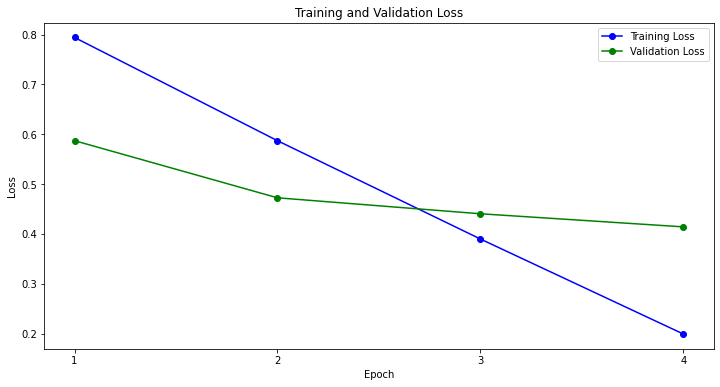

In [19]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 6)

plt.plot(df_stats['Training_Loss'], 'b-o', label='Training Loss')
plt.plot(df_stats['Valid_Loss'], 'g-o', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(df_stats.index)

plt.show()

In [20]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks, test_token_type = preprocessing_for_bert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks, test_token_type)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

Tokenizing data...


In [21]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [22]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_token_type_ids = tuple(t.to(device) for t in batch)[:3]

        # Compute logits
        with torch.no_grad():
            outputs = model(b_input_ids, b_attn_mask, b_token_type_ids)
            logits = outputs.logits
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [23]:
best_model_path = f'./models/Fine-Tuning_SciBERT_AlgoCite_UTILIZE_Context_CostSensitive_Fold_{fold}.h5'
best_model = BertForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", 
                                                           num_labels=4, 
                                                           output_attentions=False, 
                                                           output_hidden_states=False)
best_model.resize_token_embeddings(len(tokenizer))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31091, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [24]:
probs = bert_predict(best_model, test_dataloader)

In [25]:
# Get predictions from the probabilities
# threshold = 0.5
# preds = np.where(probs[:, 1] > 0.5, 1, 0)
preds = np.argmax(probs, axis=1)

In [26]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

usage_class_names = ['MENTION', 'NOTALGO', 'USE', 'EXTEND']
utilize_class_names = ['NOTUTILIZE', 'UTILIZE']

y_test_encoded = [encoding[key] for key in y_test]
accuracy = accuracy_score(y_test_encoded, preds)
precision = precision_score(y_test_encoded, preds, average='macro')
recall = recall_score(y_test_encoded, preds, average='macro')
f1 = f1_score(y_test_encoded, preds, average='macro')

print("Accuracy: %.5f%%" % (accuracy*100))
print("Precision Score: %.5f" % (precision*100))
print("Recall Score: %.5f" % (recall*100))
print("F1 Score: %.5f" % (f1*100))

print(classification_report(y_test_encoded, preds, target_names=usage_class_names, digits=3))

Accuracy: 87.61364%
Precision Score: 81.00170
Recall Score: 80.16699
F1 Score: 80.41395
              precision    recall  f1-score   support

     MENTION      0.744     0.763     0.753        38
     NOTALGO      0.906     0.939     0.922       607
         USE      0.840     0.708     0.768       171
      EXTEND      0.750     0.797     0.773        64

    accuracy                          0.876       880
   macro avg      0.810     0.802     0.804       880
weighted avg      0.875     0.876     0.874       880



In [27]:
# evaluate_roc(probs, y_test_encoded)

In [28]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_encoded, preds))

[[ 29   2   3   4]
 [  6 570  19  12]
 [  4  45 121   1]
 [  0  12   1  51]]


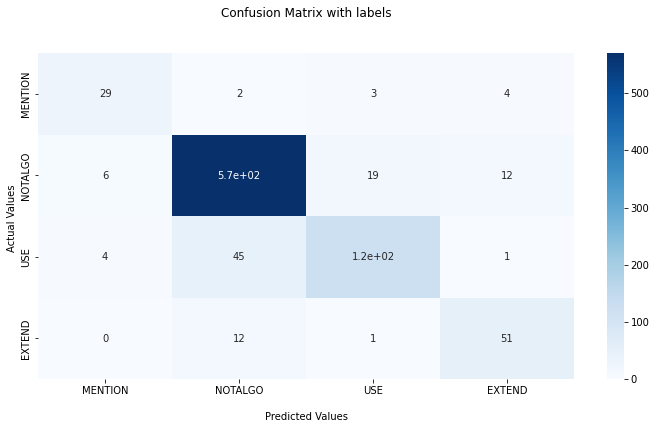

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test_encoded, preds)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(usage_class_names)
ax.yaxis.set_ticklabels(usage_class_names)

## Display the visualization of the Confusion Matrix.
plt.show()

In [30]:
inv_encoding = {v: k for k, v in encoding.items()}
pred_label = [inv_encoding[key] for key in preds]

In [31]:
df_test = pd.DataFrame({'CITATIONS_CONTEXTS': X_test, 'USAGE_LABELS': y_test, 'PRED_LABELS': pred_label})
df_test

,CITATIONS_CONTEXTS,USAGE_LABELS,PRED_LABELS
0,increases in thesnext run is determined by k2....,USE,USE
1,"difficult problem. In what follows, we proceed...",USE,MENTION
2,of so-called patches each separatingstwo diffe...,EXTEND,EXTEND
3,"the best in terms of time free scheduling, thu...",MENTION,MENTION
4,"subsequent dequeues. In this paper, we show ho...",MENTION,MENTION
...,...,...,...
875,45 log 2(1/?)+O(log log log n) such that there...,USE,USE
876,o the noiseless sequence and the observed nois...,MENTION,MENTION
877,lt on a measure of similarity between nodes ba...,MENTION,MENTION
878,rallel file systems improve coarse-grained par...,MENTION,MENTION


In [32]:
df_test.to_csv(f'./cls_results/Fine-Tuning_SciBERT_original_USAGE_{percentage}_Fold_{fold}.csv', index=False)